# Assignment 2

# Part 1: CIFAR-10

In [1]:
# -*- coding: utf-8 -*-
"""Assignment_2_Part_1_Cifar10_vp1.ipynb

Purpose: Implement image classsification nn the cifar10
dataset using a pytorch implementation of a CNN architecture (LeNet5)

Pseudocode:
1) Set Pytorch metada
- seed
- tensorboard output (logging)
- whether to transfer to gpu (cuda)

2) Import the data
- download the data
- create the pytorch datasets
    scaling
- create pytorch dataloaders
    transforms
    batch size

3) Define the model architecture, loss and optimizer

4) Define Test and Training loop
    - Train:
        a. get next batch
        b. forward pass through model
        c. calculate loss
        d. backward pass from loss (calculates the gradient for each parameter)
        e. optimizer: performs weight updates
        f. Calculate accuracy, other stats
    - Test:
        a. Calculate loss, accuracy, other stats

5) Perform Training over multiple epochs:
    Each epoch:
    - call train loop
    - call test loop
"""
0

0

In [2]:
# Step 1: Pytorch and Training Metadata

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from pathlib import Path

In [3]:
#hyperparameters
batch_size = 128
try_cuda = True
seed = 1000
# Architecture
num_classes = 10
#otherum
logging_interval = 10 # how many batches to wait before logging
logging_dir = None
grayscale = True

# 1) setting up the logging

datetime_str = datetime.now().strftime('%b%d_%H-%M-%S')

if logging_dir is None:
    runs_dir = Path("./") / Path(f"runs/")
    runs_dir.mkdir(exist_ok = True)

    logging_dir = runs_dir / Path(f"{datetime_str}")

    logging_dir.mkdir(exist_ok = True)
    logging_dir = str(logging_dir.absolute())

writer = SummaryWriter(log_dir=logging_dir)

#deciding whether to send to the cpu or not if available
if torch.cuda.is_available() and try_cuda:
    cuda = True
    torch.cuda.manual_seed(seed)
else:
    cuda = False
    torch.manual_seed(seed)

In [4]:
"""# Step 2: Data Setup"""

#transform=[insert-code: create transforms, will need to include turning data grayscale]
#train_dataset = [insert-code: download and transform cifar10 training data]
#test_dataset = [insert-code: download and transform cifar10 test data]
#train_loader = [insert-code: create train data loader]
#test_loader = [insert-code: create test data loader]
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))  # Scale values
])
# Download CIFAR-10 dataset (<datasets> is from torchvision)
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# Set up train/test loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

def check_data_loader_dim(loader):
    # Checking the dataset
    for images, labels in loader:
        print('Image batch dimensions:', images.shape)
        print('Image label dimensions:', labels.shape)
        break

check_data_loader_dim(train_loader)
check_data_loader_dim(test_loader)

Files already downloaded and verified
Files already downloaded and verified
Image batch dimensions: torch.Size([128, 1, 32, 32])
Image label dimensions: torch.Size([128])
Image batch dimensions: torch.Size([128, 1, 32, 32])
Image label dimensions: torch.Size([128])


In [5]:
"""# 3) Creating the Model"""

layer_1_n_filters = 32
layer_2_n_filters = 64
fc_1_n_nodes = 1024
padding="same"
kernel_size = 5
verbose = False

# calculating the side length of the final activation maps
#final_length = [insert-code: calculate the dimension of the output of the \
#            CNN stage before the MLP layers given the previous 2 convolutional layers \
#                with the current padding setting, kernel size and maxpooling
#            ]
## First conv layer
first_length = int((layer_1_n_filters - kernel_size + 2*((kernel_size-1)//2)) / 2) + 1
## Second conv layer
final_length = int((first_length - kernel_size + 2*((kernel_size-1)//2)) / 2) + 1

if verbose:
    print(f"final_length = {final_length}")


class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(
            #[insert-code]
            
            # LENET5 ARCHITECTURE:
            #Convolutional layer with kernel 5 x 5 and 32 filter maps followed by ReLU
            nn.Conv2d(in_channels, layer_1_n_filters, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            #Max Pooling layer subsampling by 2
            nn.MaxPool2d(kernel_size=2, stride=2),
            #Convolutional layer with kernel 5 x 5 and 64 filter maps followed by ReLU
            nn.Conv2d(layer_1_n_filters, layer_2_n_filters, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            #Max Pooling layer subsampling by 2
            nn.MaxPool2d(kernel_size=2, stride=2)
            # THESE ARE THE FC LAYERS AND PROBABILITY LAYER (in classifier below)
            #Fully Connected layer that has input 7*7*64 and output 1024
            #Fully Connected layer that has input 1024 and output 10 (for the classes)
            #Softmax layer (Softmax Regression + Softmax Nonlinearity)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(final_length*final_length*layer_2_n_filters*in_channels, fc_1_n_nodes),
            nn.Tanh(),
            nn.Linear(fc_1_n_nodes, num_classes)
        )


    def forward(self, x):
        #x = [insert-code: send input through convolutional layers]
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        #x = [insert-code: send input through MLP layers]
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = LeNet5(num_classes, grayscale=grayscale)

# I prefer the device method
#if cuda:
    #model.cuda()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
#optimizer = [insert-code: USE AN ADAM OPTIMIZER]
epochs = 5
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr) 

In [7]:
"""# Step 4: Train/Test Loop"""

# Defining the test and training loops

def train(epoch):
    running_loss = 0
    total_correct = 0
    total_samples = 0

    model.train()

    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        #[insert-code: move data to GPU]
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        logits, probas = model(data) # forward
        
        #[insert-code: finish training loop and logging metrics]
        # Calculate the loss
        loss = criterion(logits, target)
        running_loss += loss.item()
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        # Get predicted labels
        pred_labels = torch.argmax(probas, dim=1)
        total_correct += torch.sum(pred_labels == target).item()
        total_samples += data.size(0)
        
    # Log training statistics
    print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    #[insert-code: Log model parameters to TensorBoard at every epoch]    
    for name, param in model.named_parameters():
        # Mmm would this need to be updated if data was on GPU instead? I'm not using GPU tho
        writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch)
        
    accuracy = total_correct / total_samples
    loss = running_loss / total_samples
    return loss, accuracy


def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for data, target in test_loader:
            # Move data to GPU if available
            data, target = data.to(device), target.to(device)

            logits, probas = model(data)

            #[insert-code: finish testing loop and logging metrics]
            # Calculate the loss
            test_loss += criterion(logits, target).item()
            # Get predicted labels
            pred_labels = torch.argmax(probas, dim=1)
            correct += torch.sum(pred_labels == target).item()

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    print(f'Test Epoch: {epoch}\tAverage loss: {test_loss:.4f}\tAccuracy: {accuracy:.4f}')
    
    return test_loss, accuracy

In [8]:
#[insert-code: running test and training over epoch]

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
    
for epoch in range(epochs):
    train_loss, train_accuracy = train(epoch)
    test_loss, test_accuracy = test(epoch)
    
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)  

Train Epoch: 0 [31200/50000 (100%)]	Loss: 1.279427
Test Epoch: 0	Average loss: 1.3124	Accuracy: 0.5310
Train Epoch: 1 [31200/50000 (100%)]	Loss: 1.221737
Test Epoch: 1	Average loss: 1.1839	Accuracy: 0.5926
Train Epoch: 2 [31200/50000 (100%)]	Loss: 1.112790
Test Epoch: 2	Average loss: 1.1100	Accuracy: 0.6130
Train Epoch: 3 [31200/50000 (100%)]	Loss: 1.115456
Test Epoch: 3	Average loss: 1.0709	Accuracy: 0.6317
Train Epoch: 4 [31200/50000 (100%)]	Loss: 1.275291
Test Epoch: 4	Average loss: 1.0423	Accuracy: 0.6464


In [9]:
writer.close()

# Commented out IPython magic to ensure Python compatibility.
"""
#https://stackoverflow.com/questions/55970686/tensorboard-not-found-as-magic-function-in-jupyter

#seems to be working in firefox when not working in Google Chrome when running in Colab
#https://stackoverflow.com/questions/64218755/getting-error-403-in-google-colab-with-tensorboard-with-firefox


# %load_ext tensorboard
# %tensorboard --logdir [dir]

"""

'\n#https://stackoverflow.com/questions/55970686/tensorboard-not-found-as-magic-function-in-jupyter\n\n#seems to be working in firefox when not working in Google Chrome when running in Colab\n#https://stackoverflow.com/questions/64218755/getting-error-403-in-google-colab-with-tensorboard-with-firefox\n\n\n# %load_ext tensorboard\n# %tensorboard --logdir [dir]\n\n'

## 1b: Plot train/test accuracy and and train loss. 

In [10]:
import matplotlib.pyplot as plt
import numpy as np

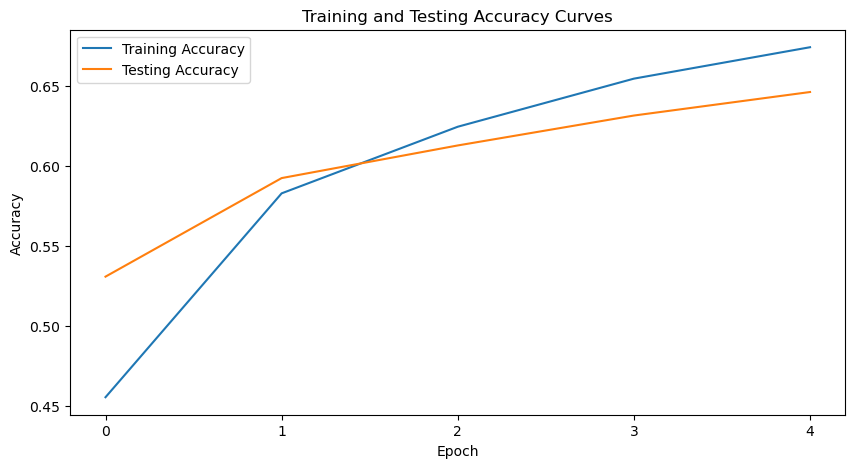

In [11]:
# Plotting accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(test_accuracy_list, label='Testing Accuracy')
plt.xticks(range(epochs))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy Curves')
plt.show()

In addition, try to search for good hyperparameters (e.g. training methods, learning rate, momentum values ...). Hint: Run a few epochs for each set of hyper-parameters and see how train/test accuracy and train loss change.

In [12]:
from torch.optim.lr_scheduler import StepLR

In [13]:
def short_hyperparam_run(opt_str, learning_rate, epochs=3, input_momentum=0.9, rmsprop_dampening=0.9, l2_wd=1e-4, use_scheduler=False):

    model = LeNet5(num_classes, grayscale=grayscale)

    if opt_str.upper() == 'ADAM':
        print("ADAM does not use momentum as a parameter\n")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_wd) 
    elif opt_str.upper() == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=input_momentum, weight_decay=l2_wd) 
    elif opt_str.upper() == 'ADAGRAD':
        print("ADAGRAD does not use momentum as a parameter\n")
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=l2_wd) 
    elif opt_str.upper() == 'NADAM':
        optimizer = optim.Nadam(model.parameters(), lr=learning_rate, momentum=input_momentum, weight_decay=l2_wd)
    elif opt_str.upper() == 'RMSPROP':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=input_momentum, weight_decay=l2_wd) #dampening=rmsprop_dampening, 
    else:
        raise ValueError('Optimizer not defined')

    if use_scheduler:
        scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    train_loss_list = []
    train_accuracy_list = []
    test_loss_list = []
    test_accuracy_list = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1} of {epochs}")
        train_loss, train_accuracy = train(epoch)
        test_loss, test_accuracy = test(epoch)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)  
        print()

    # Plotting accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy_list, label='Training Accuracy')
    plt.plot(test_accuracy_list, label='Testing Accuracy')
    plt.xticks(range(epochs))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Testing Accuracy Curves')
    plt.show()

ADAM does not use momentum as a parameter

Epoch 1 of 3
Train Epoch: 0 [31200/50000 (100%)]	Loss: 0.754193
Test Epoch: 0	Average loss: 1.0032	Accuracy: 0.6539

Epoch 2 of 3
Train Epoch: 1 [31200/50000 (100%)]	Loss: 0.953991
Test Epoch: 1	Average loss: 1.0089	Accuracy: 0.6554

Epoch 3 of 3
Train Epoch: 2 [31200/50000 (100%)]	Loss: 0.689386
Test Epoch: 2	Average loss: 1.0013	Accuracy: 0.6692



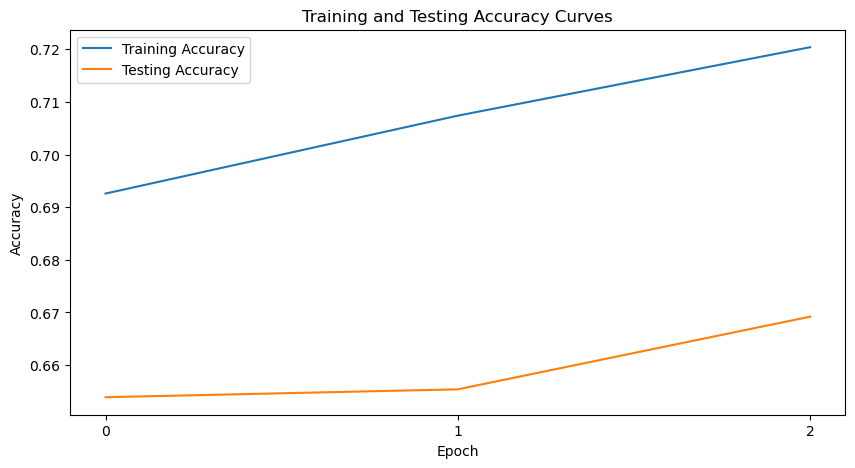

In [14]:
#short_hyperparam_run(optimizer, learning_rate, epochs=3, input_momentum=0.9, rmsprop_dampening=0.9, l2_wd=1e-4, use_scheduler=False)

short_hyperparam_run(opt_str='ADAM', learning_rate=1e-3, l2_wd=1e-4)

Epoch 1 of 3
Train Epoch: 0 [31200/50000 (100%)]	Loss: 0.782205
Test Epoch: 0	Average loss: 1.0030	Accuracy: 0.6691

Epoch 2 of 3
Train Epoch: 1 [31200/50000 (100%)]	Loss: 0.589974
Test Epoch: 1	Average loss: 0.9972	Accuracy: 0.6691

Epoch 3 of 3
Train Epoch: 2 [31200/50000 (100%)]	Loss: 0.714264
Test Epoch: 2	Average loss: 0.9818	Accuracy: 0.6714



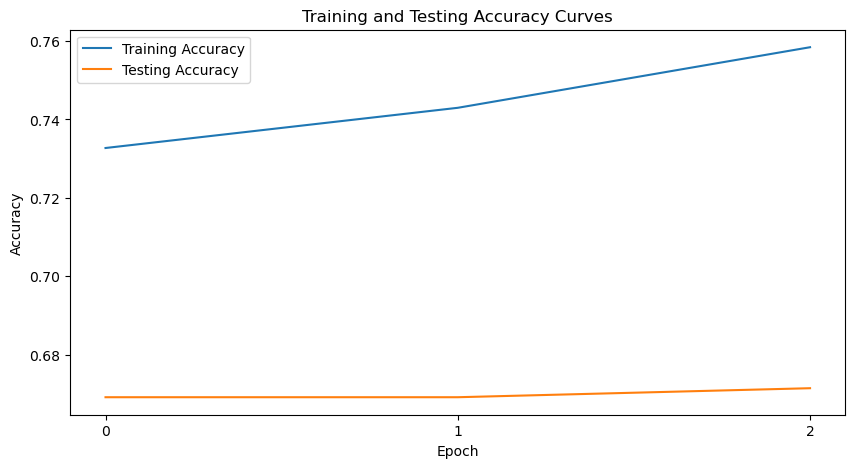

In [15]:
short_hyperparam_run(opt_str='SGD', learning_rate=1e-3, l2_wd=1e-4)

ADAGRAD does not use momentum as a parameter

Epoch 1 of 3
Train Epoch: 0 [31200/50000 (100%)]	Loss: 0.748097
Test Epoch: 0	Average loss: 0.9939	Accuracy: 0.6707

Epoch 2 of 3
Train Epoch: 1 [31200/50000 (100%)]	Loss: 0.586153
Test Epoch: 1	Average loss: 0.9954	Accuracy: 0.6794

Epoch 3 of 3
Train Epoch: 2 [31200/50000 (100%)]	Loss: 0.825784
Test Epoch: 2	Average loss: 1.0347	Accuracy: 0.6707



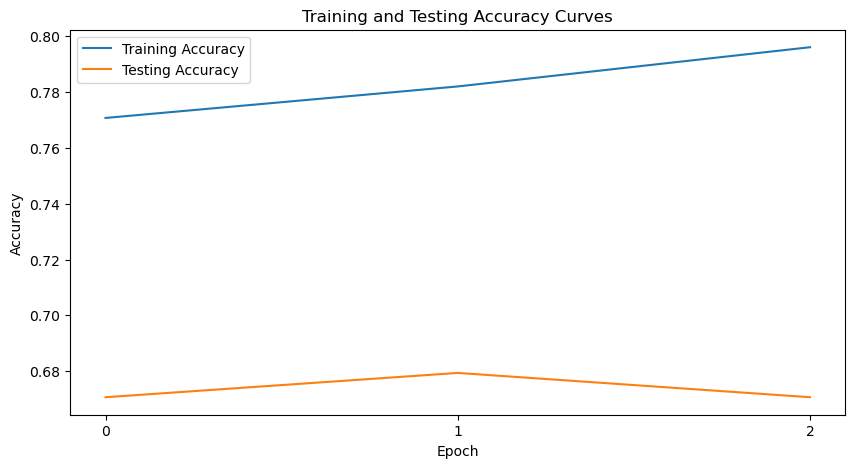

In [16]:
short_hyperparam_run(opt_str='ADAGRAD', learning_rate=1e-3, l2_wd=1e-4)

Epoch 1 of 3
Train Epoch: 0 [31200/50000 (100%)]	Loss: 0.477836
Test Epoch: 0	Average loss: 0.9744	Accuracy: 0.6872

Epoch 2 of 3
Train Epoch: 1 [31200/50000 (100%)]	Loss: 0.543636
Test Epoch: 1	Average loss: 1.0108	Accuracy: 0.6847

Epoch 3 of 3
Train Epoch: 2 [31200/50000 (100%)]	Loss: 0.532319
Test Epoch: 2	Average loss: 1.0537	Accuracy: 0.6845



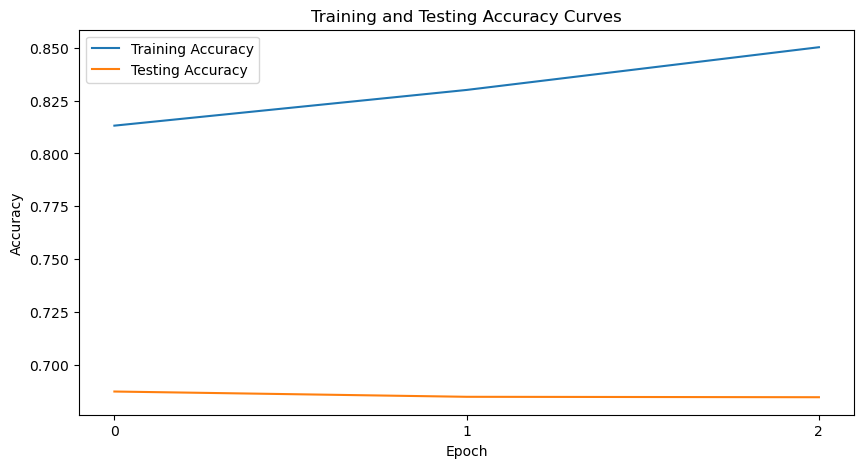

In [17]:
short_hyperparam_run(opt_str='RMSPROP', learning_rate=1e-3, l2_wd=1e-4)

RMSProp performs the best, so now checking what the optimal learning rate is

Epoch 1 of 3
Train Epoch: 0 [31200/50000 (100%)]	Loss: 0.335430
Test Epoch: 0	Average loss: 1.0675	Accuracy: 0.6897

Epoch 2 of 3
Train Epoch: 1 [31200/50000 (100%)]	Loss: 0.361722
Test Epoch: 1	Average loss: 1.0836	Accuracy: 0.6909

Epoch 3 of 3
Train Epoch: 2 [31200/50000 (100%)]	Loss: 0.338114
Test Epoch: 2	Average loss: 1.1183	Accuracy: 0.6978



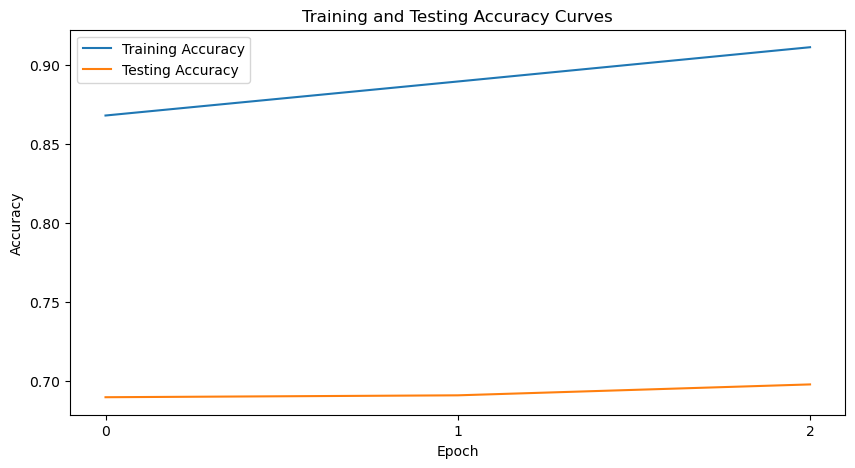

In [22]:
short_hyperparam_run(opt_str='RMSPROP', learning_rate=1e-2, l2_wd=1e-4)

Epoch 1 of 3
Train Epoch: 0 [31200/50000 (100%)]	Loss: 0.342832
Test Epoch: 0	Average loss: 1.2002	Accuracy: 0.6894

Epoch 2 of 3
Train Epoch: 1 [31200/50000 (100%)]	Loss: 0.245848
Test Epoch: 1	Average loss: 1.2904	Accuracy: 0.6871

Epoch 3 of 3
Train Epoch: 2 [31200/50000 (100%)]	Loss: 0.115727
Test Epoch: 2	Average loss: 1.3250	Accuracy: 0.6919



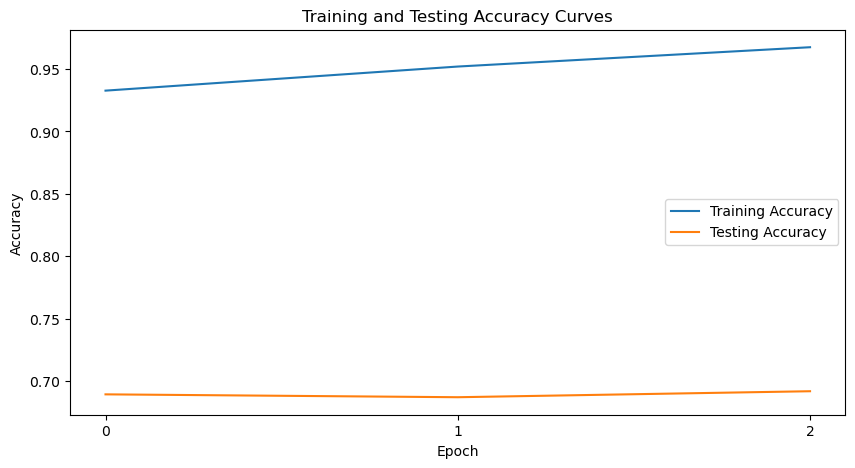

In [23]:
short_hyperparam_run(opt_str='RMSPROP', learning_rate=1e-4, l2_wd=1e-4)

Now checking the best momentum value

In [ ]:
short_hyperparam_run(opt_str='RMSPROP', learning_rate=1e-2, l2_wd=1e-4, input_momentum=0.5)

In [ ]:
short_hyperparam_run(opt_str='RMSPROP', learning_rate=1e-2, l2_wd=1e-4, input_momentum=0.5)

> __Conclusion:__ It is clear from the above that RMSProp achieves the best accuracy, across all tested optimizers. In addition, learning rate was tested and RMSProp's best performing learning rate was 1e-4. From the momentum tests, it was found that the default momentum (eg 0.9) performs the best. Thus, the optimal hyperparameter set was using RMSProp with a learning rate of 1e-4 and a momentum value of 0.9.

## 1c) Visualize the Trained Network: 
> Visualize the first convolutional layer’s weights. They should look like Gabor filters (edge detectors).

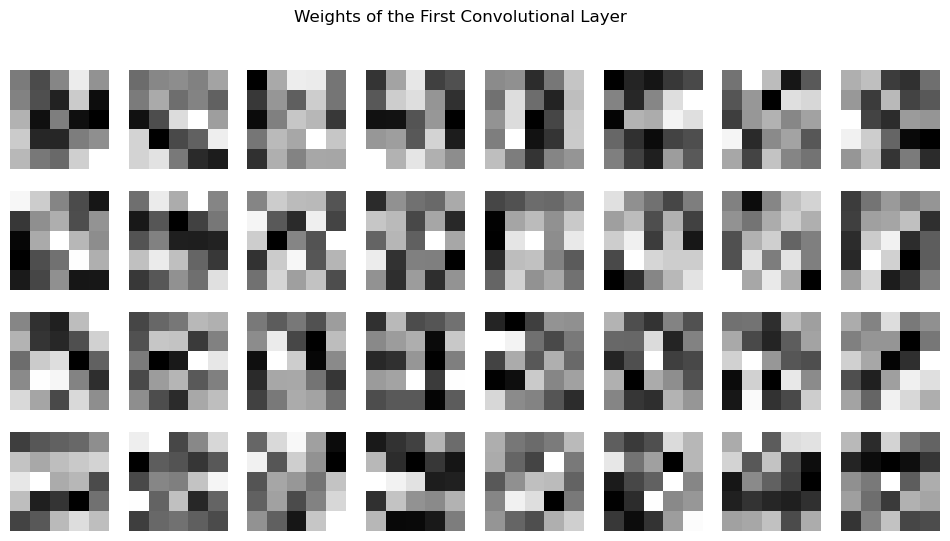

In [18]:
# Accessing the weights of the first convolutional layer
conv1_weights = model.features[0].weight.data

# Visualizing the weights
fig, axs = plt.subplots(4, 8, figsize=(12, 6))
fig.suptitle('Weights of the First Convolutional Layer')

for i in range(4):
    for j in range(8):
        filter_index = i * 8 + j
        filter_weights = conv1_weights[filter_index].cpu().numpy()
        axs[i, j].imshow(filter_weights[0], cmap='gray')  # Assuming single-channel filters
        axs[i, j].axis('off')

plt.show()


Also, show the statistics of the activations in the convolutional layers on test images.

In [19]:
class ActivationStatistics:
    def __init__(self, model, layer_index):
        self.model = model
        self.layer_index = layer_index
        self.activations = []
        # Register a hook for the chosen layer
        self.hook = model.features[layer_index].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # Save the activations during the forward pass
        self.activations.append(output.detach().cpu().numpy())

    def close(self):
        # Remove the hook when done
        self.hook.remove()

    def plot_histogram(self):
        # Plot the histogram of activations
        activations = torch.cat([torch.from_numpy(act.flatten()) for act in self.activations])
        plt.figure()
        plt.hist(activations.numpy(), bins=50)
        plt.xlabel('Output magnitude')
        plt.ylabel('Count')
        plt.title(f'Convolutional Layer Activations {self.layer_index + 1}\n(μ = black, σ boundaries = red)')
        plt.axvline(activations.mean(), color='k', linestyle='dashed', linewidth=3)
        plt.axvline(activations.mean() - activations.var()**0.5, color='r', linestyle='dashed', linewidth=2)
        plt.axvline(activations.mean() + activations.var()**0.5, color='r', linestyle='dashed', linewidth=2)
        plt.show()


First convoluional layer

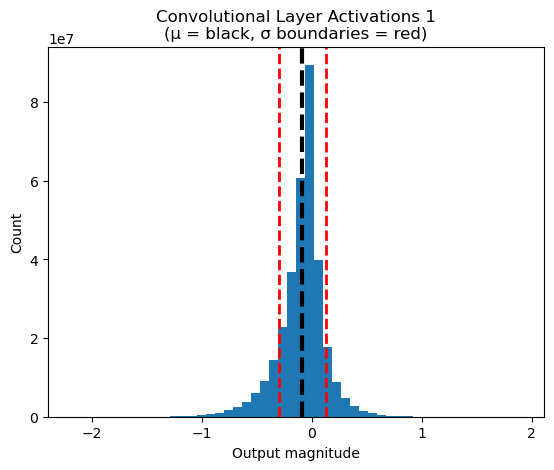

In [20]:
activation_stats_first_layer = ActivationStatistics(model, layer_index=0)

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        # Don't need the outputs, just want the activations to be extractable
        _ = model(data)

activation_stats_first_layer.plot_histogram()
activation_stats_first_layer.close()

Second convolutional layer

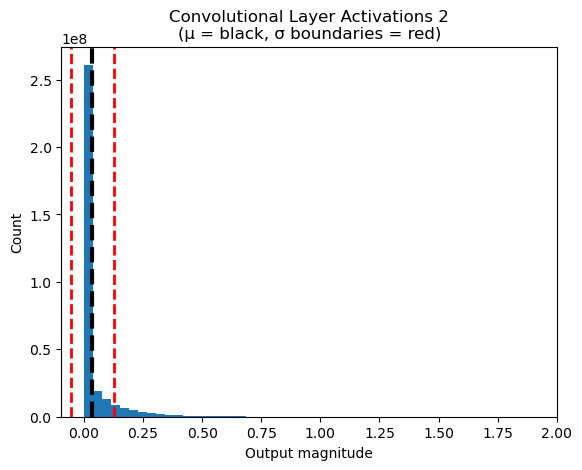

In [21]:
activation_stats_second_layer = ActivationStatistics(model, layer_index=1)

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        _ = model(data)

activation_stats_second_layer.plot_histogram()
activation_stats_second_layer.close()

# Part 2: Visualizing and Understanding Convolutional Networks Paper Notes
- This paper investigated the interpretability of CNNs, looking to understand both what these networks do internally as well as why they are so effective.
- The authors introduce a method for visualizing what each layer of the CNN is learning / focusing on, namely by extending a prior work that introduced de-convolutional neural networks (that paper tried to use dCNNs for learning tasks, whereas in this paper dCNNs are only used for probing the trained CNN).
- The main contribution of this paper is their work in finding a way to map the feature activity in the intermediate hidden layers back to the original input pixel space, allowing you to directly see what is causing the different intermediate layers to activate.
- Their results show the hierarchical nature of the features in the network, as each layer essentially builds / combines the previous layer's patterns to learn more complex/abstract patterns. 
- This method is also useful for double checking what the model is actually learning, namely looking at this such as occlusion sensitivity (which they use to measure if the model is just learning from the background instead of the actual object in the image).
- Finally, they run experiments showing how well their model performs (extending the state of the art) and how their models can generalize across different (large) datasets.